In [3]:
import pandas as pd
import numpy as np

def loader():
    """Reading data from keys"""
    with open("data/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data/data_{}.csv".format(str(key)))

    return dictex

In [4]:
df = loader()

In [5]:
# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
import sys
import pickle

def create_model(neurons=1):
    # create model
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=17))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model
    
def get_best_parameters(samples, targets):
    model = KerasRegressor(build_fn=create_model, epochs=20, batch_size=50, verbose=0) 

    # Define the range
    neurons = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
    batch_size = [20, 40, 50, 60, 80, 100]
    epochs = [10, 20, 40, 50]
    param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs)
    
    dnn_random = RandomizedSearchCV(estimator = model, param_distributions = param_grid, cv = 3, verbose=2, n_iter = 20)
    dnn_random.fit(samples, targets)
    
    return dnn_random.best_params_
    

def fit_nn(samples, targets, neurons=238, epochs=20, batch_size=50):
    model = Sequential()
    model.add(Dense(neurons, activation='relu',
             input_shape=(samples.shape[1],)))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    model.fit(samples, targets,
             epochs=epochs, batch_size=batch_size, verbose=0)
    
    #p = pickle.dumps(model)
    #print(sys.getsizeof(p))
    return model

def forecast_nn(model, samples):
    predictions = model.predict(samples)
    return predictions

def normalize(train, test):
    mean = train.mean(axis=0)    
    train -= mean
    std = train.std(axis=0)
    train /= std

    test -= mean
    test /= std
    return train, test

def getValues(data):
    data.set_index("Date Time", inplace=True)
    included = np.array(data[INDEPENDENT_FEATURES + ['surf_temp_sqerror']].notnull().all(axis=1))
    rsi = {
        "data": data.loc[included, INDEPENDENT_FEATURES].values.astype(np.float), 
        "target": data.loc[included, 'surf_temp_sqerror'].values.astype(np.float)
    }
    return train_test_split(rsi["data"], rsi["target"], test_size=0.3, random_state=0)


Using TensorFlow backend.


In [8]:
dfTest = loader()
neuron_params = dict()

del dfTest[(1419, 1)]
del dfTest[(1419, 5)]
del dfTest[(1419, 9)]
del dfTest[(1419, 18)]
del dfTest[(1433, 1)]
del dfTest[(1433, 5)]
del dfTest[(1433, 9)]
del dfTest[(1433, 18)]
del dfTest[(1440, 1)]
del dfTest[(1440, 5)]
del dfTest[(1440, 9)]
del dfTest[(1440, 18)]

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in dfTest.keys():
    if allowed_key(key):
        X_train, X_test, y_train, y_test = getValues(dfTest[key])
        
        best_params = get_best_parameters(X_train, y_train)
        neuron_params[key] = best_params
        print(key, best_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] neurons=10, epochs=50, batch_size=60 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............. neurons=10, epochs=50, batch_size=60, total=   6.5s
[CV] neurons=10, epochs=50, batch_size=60 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] ............. neurons=10, epochs=50, batch_size=60, total=   6.4s
[CV] neurons=10, epochs=50, batch_size=60 ............................
[CV] ............. neurons=10, epochs=50, batch_size=60, total=   5.7s
[CV] neurons=235, epochs=40, batch_size=100 ..........................
[CV] ........... neurons=235, epochs=40, batch_size=100, total=   6.3s
[CV] neurons=235, epochs=40, batch_size=100 ..........................
[CV] ........... neurons=235, epochs=40, batch_size=100, total=   5.8s
[CV] neurons=235, epochs=40, batch_size=100 ..........................
[CV] ........... neurons=235, epochs=40, batch_size=100, total=   5.9s
[CV] neurons=203, epochs=50, batch_size=100 ..........................
[CV] ........... neurons=203, epochs=50, batch_size=100, total=   7.4s
[CV] neurons=203, epochs=50, batch_size=100 ..........................
[CV] ........... neurons=203, epochs=50, batch_size=100, total=   6.2s
[CV] neurons=203, epochs=50, batch_size=100 ..........................
[CV] .

[CV] ........... neurons=171, epochs=40, batch_size=100, total=  10.3s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  9.6min finished


(1433, 5) {'neurons': 267, 'epochs': 50, 'batch_size': 40}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] neurons=138, epochs=40, batch_size=60 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ neurons=138, epochs=40, batch_size=60, total=  12.1s
[CV] neurons=138, epochs=40, batch_size=60 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s


[CV] ............ neurons=138, epochs=40, batch_size=60, total=   9.3s
[CV] neurons=138, epochs=40, batch_size=60 ...........................
[CV] ............ neurons=138, epochs=40, batch_size=60, total=  12.6s
[CV] neurons=235, epochs=20, batch_size=20 ...........................
[CV] ............ neurons=235, epochs=20, batch_size=20, total=  14.7s
[CV] neurons=235, epochs=20, batch_size=20 ...........................
[CV] ............ neurons=235, epochs=20, batch_size=20, total=  12.6s
[CV] neurons=235, epochs=20, batch_size=20 ...........................
[CV] ............ neurons=235, epochs=20, batch_size=20, total=  10.5s
[CV] neurons=171, epochs=40, batch_size=50 ...........................
[CV] ............ neurons=171, epochs=40, batch_size=50, total=   9.5s
[CV] neurons=171, epochs=40, batch_size=50 ...........................
[CV] ............ neurons=171, epochs=40, batch_size=50, total=  10.0s
[CV] neurons=171, epochs=40, batch_size=50 ...........................
[CV] .

[CV] ........... neurons=235, epochs=20, batch_size=100, total=  12.9s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 11.9min finished


(1433, 9) {'neurons': 267, 'epochs': 40, 'batch_size': 40}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] neurons=74, epochs=40, batch_size=20 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............. neurons=74, epochs=40, batch_size=20, total=  33.8s
[CV] neurons=74, epochs=40, batch_size=20 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.2s remaining:    0.0s


[CV] ............. neurons=74, epochs=40, batch_size=20, total=  32.2s
[CV] neurons=74, epochs=40, batch_size=20 ............................
[CV] ............. neurons=74, epochs=40, batch_size=20, total=  34.2s
[CV] neurons=235, epochs=10, batch_size=60 ...........................
[CV] ............ neurons=235, epochs=10, batch_size=60, total=  12.8s
[CV] neurons=235, epochs=10, batch_size=60 ...........................
[CV] ............ neurons=235, epochs=10, batch_size=60, total=  14.2s
[CV] neurons=235, epochs=10, batch_size=60 ...........................
[CV] ............ neurons=235, epochs=10, batch_size=60, total=  12.1s
[CV] neurons=267, epochs=10, batch_size=50 ...........................
[CV] ............ neurons=267, epochs=10, batch_size=50, total=  12.6s
[CV] neurons=267, epochs=10, batch_size=50 ...........................
[CV] ............ neurons=267, epochs=10, batch_size=50, total=  12.6s
[CV] neurons=267, epochs=10, batch_size=50 ...........................
[CV] .

[CV] ........... neurons=300, epochs=20, batch_size=100, total=  16.4s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 19.1min finished
/Users/Jesper/miniconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(1433, 18) {'neurons': 235, 'epochs': 50, 'batch_size': 40}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] neurons=235, epochs=50, batch_size=100 ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... neurons=235, epochs=50, batch_size=100, total=  17.4s
[CV] neurons=235, epochs=50, batch_size=100 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s remaining:    0.0s


[CV] ........... neurons=235, epochs=50, batch_size=100, total=  21.6s
[CV] neurons=235, epochs=50, batch_size=100 ..........................
[CV] ........... neurons=235, epochs=50, batch_size=100, total=  18.2s
[CV] neurons=74, epochs=20, batch_size=60 ............................
[CV] ............. neurons=74, epochs=20, batch_size=60, total=  18.7s
[CV] neurons=74, epochs=20, batch_size=60 ............................
[CV] ............. neurons=74, epochs=20, batch_size=60, total=  19.1s
[CV] neurons=74, epochs=20, batch_size=60 ............................
[CV] ............. neurons=74, epochs=20, batch_size=60, total=  15.2s
[CV] neurons=203, epochs=40, batch_size=80 ...........................
[CV] ............ neurons=203, epochs=40, batch_size=80, total=  18.3s
[CV] neurons=203, epochs=40, batch_size=80 ...........................
[CV] ............ neurons=203, epochs=40, batch_size=80, total=  16.9s
[CV] neurons=203, epochs=40, batch_size=80 ...........................
[CV] .

[CV] ............. neurons=10, epochs=50, batch_size=20, total=  34.6s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 19.7min finished
/Users/Jesper/miniconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(1440, 1) {'neurons': 300, 'epochs': 40, 'batch_size': 20}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] neurons=171, epochs=50, batch_size=60 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ neurons=171, epochs=50, batch_size=60, total=  20.0s
[CV] neurons=171, epochs=50, batch_size=60 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.2s remaining:    0.0s


[CV] ............ neurons=171, epochs=50, batch_size=60, total=  20.1s
[CV] neurons=171, epochs=50, batch_size=60 ...........................
[CV] ............ neurons=171, epochs=50, batch_size=60, total=  20.1s
[CV] neurons=138, epochs=10, batch_size=60 ...........................
[CV] ............ neurons=138, epochs=10, batch_size=60, total=  13.0s
[CV] neurons=138, epochs=10, batch_size=60 ...........................
[CV] ............ neurons=138, epochs=10, batch_size=60, total=  13.1s
[CV] neurons=138, epochs=10, batch_size=60 ...........................
[CV] ............ neurons=138, epochs=10, batch_size=60, total=  13.2s
[CV] neurons=10, epochs=50, batch_size=100 ...........................
[CV] ............ neurons=10, epochs=50, batch_size=100, total=  16.5s
[CV] neurons=10, epochs=50, batch_size=100 ...........................
[CV] ............ neurons=10, epochs=50, batch_size=100, total=  16.5s
[CV] neurons=10, epochs=50, batch_size=100 ...........................
[CV] .

[CV] ............ neurons=106, epochs=10, batch_size=60, total=  15.3s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 21.4min finished


(1440, 5) {'neurons': 203, 'epochs': 40, 'batch_size': 20}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] neurons=300, epochs=50, batch_size=50 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ neurons=300, epochs=50, batch_size=50, total=  37.6s
[CV] neurons=300, epochs=50, batch_size=50 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.3s remaining:    0.0s


[CV] ............ neurons=300, epochs=50, batch_size=50, total=  33.1s
[CV] neurons=300, epochs=50, batch_size=50 ...........................
[CV] ............ neurons=300, epochs=50, batch_size=50, total=  29.5s
[CV] neurons=74, epochs=20, batch_size=20 ............................
[CV] ............. neurons=74, epochs=20, batch_size=20, total=  24.9s
[CV] neurons=74, epochs=20, batch_size=20 ............................
[CV] ............. neurons=74, epochs=20, batch_size=20, total=  24.5s
[CV] neurons=74, epochs=20, batch_size=20 ............................
[CV] ............. neurons=74, epochs=20, batch_size=20, total=  24.9s
[CV] neurons=267, epochs=50, batch_size=20 ...........................
[CV] ............ neurons=267, epochs=50, batch_size=20, total=  45.0s
[CV] neurons=267, epochs=50, batch_size=20 ...........................
[CV] ............ neurons=267, epochs=50, batch_size=20, total=  45.3s
[CV] neurons=267, epochs=50, batch_size=20 ...........................
[CV] .

[CV] ............. neurons=10, epochs=50, batch_size=60, total=  34.1s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 30.7min finished


(1440, 9) {'neurons': 267, 'epochs': 50, 'batch_size': 20}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] neurons=138, epochs=10, batch_size=40 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ neurons=138, epochs=10, batch_size=40, total=  23.5s
[CV] neurons=138, epochs=10, batch_size=40 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.8s remaining:    0.0s


[CV] ............ neurons=138, epochs=10, batch_size=40, total=  23.6s
[CV] neurons=138, epochs=10, batch_size=40 ...........................
[CV] ............ neurons=138, epochs=10, batch_size=40, total=  33.3s
[CV] neurons=203, epochs=20, batch_size=50 ...........................
[CV] ............ neurons=203, epochs=20, batch_size=50, total=  25.7s
[CV] neurons=203, epochs=20, batch_size=50 ...........................
[CV] ............ neurons=203, epochs=20, batch_size=50, total=  25.5s
[CV] neurons=203, epochs=20, batch_size=50 ...........................
[CV] ............ neurons=203, epochs=20, batch_size=50, total=  28.6s
[CV] neurons=74, epochs=50, batch_size=60 ............................
[CV] ............. neurons=74, epochs=50, batch_size=60, total=  33.1s
[CV] neurons=74, epochs=50, batch_size=60 ............................
[CV] ............. neurons=74, epochs=50, batch_size=60, total=  33.4s
[CV] neurons=74, epochs=50, batch_size=60 ............................
[CV] .

[CV] ............. neurons=42, epochs=40, batch_size=50, total=  47.2s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 35.8min finished
/Users/Jesper/miniconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(1440, 18) {'neurons': 300, 'epochs': 50, 'batch_size': 20}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] neurons=171, epochs=50, batch_size=20 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ neurons=171, epochs=50, batch_size=20, total= 1.2min
[CV] neurons=171, epochs=50, batch_size=20 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ............ neurons=171, epochs=50, batch_size=20, total= 1.2min
[CV] neurons=171, epochs=50, batch_size=20 ...........................
[CV] ............ neurons=171, epochs=50, batch_size=20, total= 1.1min
[CV] neurons=106, epochs=50, batch_size=100 ..........................
[CV] ........... neurons=106, epochs=50, batch_size=100, total=  31.8s
[CV] neurons=106, epochs=50, batch_size=100 ..........................
[CV] ........... neurons=106, epochs=50, batch_size=100, total=  30.6s
[CV] neurons=106, epochs=50, batch_size=100 ..........................
[CV] ........... neurons=106, epochs=50, batch_size=100, total=  31.3s
[CV] neurons=42, epochs=50, batch_size=100 ...........................
[CV] ............ neurons=42, epochs=50, batch_size=100, total=  31.0s
[CV] neurons=42, epochs=50, batch_size=100 ...........................
[CV] ............ neurons=42, epochs=50, batch_size=100, total=  30.1s
[CV] neurons=42, epochs=50, batch_size=100 ...........................
[CV] .

KeyboardInterrupt: 

In [7]:
dfTest = loader()
neuron_params = dict()

del dfTest[(1419, 1)]
del dfTest[(1419, 5)]
del dfTest[(1419, 9)]
del dfTest[(1419, 18)]
del dfTest[(1433, 1)]
del dfTest[(1433, 5)]
del dfTest[(1433, 9)]
del dfTest[(1433, 18)]
del dfTest[(1440, 1)]
del dfTest[(1440, 5)]
del dfTest[(1440, 9)]
del dfTest[(1440, 18)]
del dfTest[(1417, 1)]

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in dfTest.keys():
    if allowed_key(key):
        X_train, X_test, y_train, y_test = getValues(dfTest[key])
        
        best_params = get_best_parameters(X_train, y_train)
        neuron_params[key] = best_params
        print(key, best_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] neurons=235, epochs=50, batch_size=20 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ neurons=235, epochs=50, batch_size=20, total=   6.4s
[CV] neurons=235, epochs=50, batch_size=20 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] ............ neurons=235, epochs=50, batch_size=20, total=   7.3s
[CV] neurons=235, epochs=50, batch_size=20 ...........................
[CV] ............ neurons=235, epochs=50, batch_size=20, total=   5.9s
[CV] neurons=10, epochs=50, batch_size=40 ............................
[CV] ............. neurons=10, epochs=50, batch_size=40, total=   3.7s
[CV] neurons=10, epochs=50, batch_size=40 ............................
[CV] ............. neurons=10, epochs=50, batch_size=40, total=   3.3s
[CV] neurons=10, epochs=50, batch_size=40 ............................
[CV] ............. neurons=10, epochs=50, batch_size=40, total=   2.6s
[CV] neurons=203, epochs=20, batch_size=50 ...........................
[CV] ............ neurons=203, epochs=20, batch_size=50, total=   1.7s
[CV] neurons=203, epochs=20, batch_size=50 ...........................
[CV] ............ neurons=203, epochs=20, batch_size=50, total=   1.6s
[CV] neurons=203, epochs=20, batch_size=50 ...........................
[CV] .

[CV] ........... neurons=106, epochs=40, batch_size=100, total=   5.8s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.3min finished


(1417, 5) {'neurons': 235, 'epochs': 50, 'batch_size': 20}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] neurons=235, epochs=40, batch_size=60 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ neurons=235, epochs=40, batch_size=60, total=   6.3s
[CV] neurons=235, epochs=40, batch_size=60 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV] ............ neurons=235, epochs=40, batch_size=60, total=   6.1s
[CV] neurons=235, epochs=40, batch_size=60 ...........................
[CV] ............ neurons=235, epochs=40, batch_size=60, total=   8.4s
[CV] neurons=300, epochs=50, batch_size=40 ...........................
[CV] ............ neurons=300, epochs=50, batch_size=40, total=  11.2s
[CV] neurons=300, epochs=50, batch_size=40 ...........................
[CV] ............ neurons=300, epochs=50, batch_size=40, total=  10.7s
[CV] neurons=300, epochs=50, batch_size=40 ...........................
[CV] ............ neurons=300, epochs=50, batch_size=40, total=  13.4s
[CV] neurons=138, epochs=50, batch_size=60 ...........................
[CV] ............ neurons=138, epochs=50, batch_size=60, total=   5.9s
[CV] neurons=138, epochs=50, batch_size=60 ...........................
[CV] ............ neurons=138, epochs=50, batch_size=60, total=   6.1s
[CV] neurons=138, epochs=50, batch_size=60 ...........................
[CV] .

[CV] ............ neurons=267, epochs=50, batch_size=50, total=  14.2s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  8.4min finished


(1417, 9) {'neurons': 300, 'epochs': 40, 'batch_size': 20}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] neurons=10, epochs=50, batch_size=50 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............. neurons=10, epochs=50, batch_size=50, total=   9.0s
[CV] neurons=10, epochs=50, batch_size=50 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s


[CV] ............. neurons=10, epochs=50, batch_size=50, total=  12.1s
[CV] neurons=10, epochs=50, batch_size=50 ............................
[CV] ............. neurons=10, epochs=50, batch_size=50, total=   7.9s
[CV] neurons=171, epochs=20, batch_size=80 ...........................
[CV] ............ neurons=171, epochs=20, batch_size=80, total=   5.8s
[CV] neurons=171, epochs=20, batch_size=80 ...........................
[CV] ............ neurons=171, epochs=20, batch_size=80, total=   8.3s
[CV] neurons=171, epochs=20, batch_size=80 ...........................
[CV] ............ neurons=171, epochs=20, batch_size=80, total=   7.3s
[CV] neurons=267, epochs=40, batch_size=50 ...........................
[CV] ............ neurons=267, epochs=40, batch_size=50, total=  11.9s
[CV] neurons=267, epochs=40, batch_size=50 ...........................
[CV] ............ neurons=267, epochs=40, batch_size=50, total=  11.8s
[CV] neurons=267, epochs=40, batch_size=50 ...........................
[CV] .

[CV] ............ neurons=300, epochs=40, batch_size=60, total=  11.5s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 12.3min finished
/Users/Jesper/miniconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(1417, 18) {'neurons': 171, 'epochs': 50, 'batch_size': 20}


In [20]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

def plotPredictions(key, true, predictions):
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    pyplot.scatter(true, predictions, color="red", alpha=0.5, s=10)
    pyplot.xlim(0,20)
    pyplot.ylim(0,20)
    pyplot.plot(range(60), color='black', alpha=0.2)
    pyplot.grid()
    pyplot.title(key, fontsize=16)
    pyplot.xlabel('surf_temp_sqerror')
    pyplot.ylabel('Estimated surf_temp_sqerror')

In [21]:
def experiment(repeats, data, key):
    X_train, X_test, y_train, y_test = getValues(data)
    X_train, X_test = normalize(X_train, X_test)
    
    MSE_benchmark = 100
    index_val = 20
    predictionsBest = list()
    trueBest = list()

    error_scores = list()
    results = pd.DataFrame()
    print(key)
    print(X_train.shape)
    for r in range(repeats):
        forest_model = fit_nn(X_train, y_train)

        predictions = forecast_nn(forest_model, X_test)
        true = y_test
    
        # report performance
        mse = mean_squared_error(true, predictions)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
        # plotPredictions(key, true, predictions)
        if (mse < MSE_benchmark):
            MSE_benchmark = mse
            predictionsBest = predictions
            trueBest = true
            index_val = r
    print(index_val, )
    return trueBest, predictionsBest

In [22]:
%matplotlib inline

repeats = 10
features = 1
results = dict()

trueVals = []
predictedVals = []

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        true, predictions = experiment(repeats, df[key], key)
        trueVals.extend(true)
        predictedVals.extend(predictions)
    

(1419, 1)
(2199, 17)


KeyboardInterrupt: 

In [24]:
diffValsSquared = (np.asarray(trueVals) - np.asarray(predictedVals)) ** 2
diffValsSquared = np.concatenate(trueVals)

In [37]:
diffValsSquared = []
for i in range(len(trueVals)):
    diffValsSquared.append((trueVals[i] - predictedVals[i]) ** 2)

In [39]:
diffVals = [math.sqrt(number) for number in diffValsSquared]

Text(0, 0.5, 'Estimated surf_temp_sqerror')

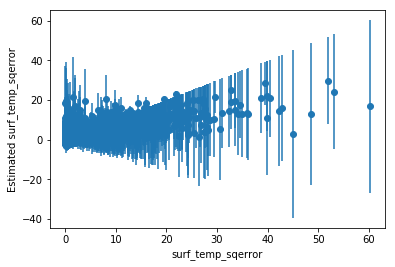

In [41]:
plt.errorbar(trueVals, predictedVals, yerr=diffVals, fmt='o')
plt.xlabel('surf_temp_sqerror')
plt.ylabel('Estimated surf_temp_sqerror')

In [41]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results/dnn/results_{}.csv".format(str(key)))

    with open("results/dnn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)

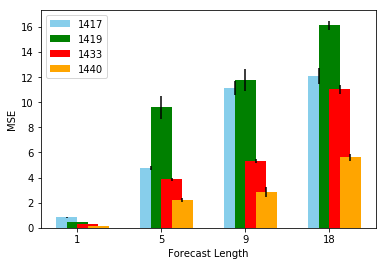

In [14]:
def loader():
    """Reading data from keys"""
    with open("results/dnn/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("results/dnn/results_{}.csv".format(str(key)))

    return dictex

results = loader()
graph_data = dict()
std_data = dict()
keys = [1417, 1419, 1433, 1440]

for key in keys:
    d = []
    st = []
    for i in [1, 5, 9, 18]:
        t = sum(results[(key, i)].values) / float(len(results[(key, i)]))
        s = np.std(results[(key, i)])[1]
        d.append(t[1])
        st.append(s)
    graph_data[key] = d
    std_data[key] = st

# Data for plotting
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ind = np.arange(len(graph_data[1417]))  # the x locations for the groups
width = 0.25  # the width of the bars

means, std = np.around(graph_data[1417], decimals=3), np.around(std_data[1417], decimals=3)
ax.bar(ind - width/2, means, width, yerr=std,
            color='SkyBlue', label=1417, align='center')

means, std = np.around(graph_data[1419], decimals=3), np.around(std_data[1419], decimals=3)
ax.bar(ind, means, width, yerr=std,
            color='Green', label=1419, align='center')

means, std = np.around(graph_data[1433], decimals=3), np.around(std_data[1433], decimals=3)
ax.bar(ind + width/2, means, width, yerr=std,
            color='Red', label=1433, align='center')

means, std = np.around(graph_data[1440], decimals=3), np.around(std_data[1440], decimals=3)
ax.bar(ind + width/2 + width/2, means, width, yerr=std,
            color='Orange', label=1440, align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_xlabel('Forecast Length')
ax.set_xticks(ind)
ax.set_xticklabels((1, 5, 9, 18))
ax.legend()


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


#autolabel(rects1, "left")
#autolabel(rects2, "right")

plt.show()

In [ ]:
# (1419, 1) {'neurons': 74, 'epochs': 100, 'batch_size': 10}
# (1419, 5) {'neurons': 235, 'epochs': 100, 'batch_size': 20}
# (1419, 9) {'neurons': 267, 'epochs': 40, 'batch_size': 20}
# (1419, 18) {'neurons': 138, 'epochs': 40, 'batch_size': 10}
# (1433, 1) {'neurons': 138, 'epochs': 100, 'batch_size': 10}
# 